In [1]:
import sklearn
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

### The american sign language contains 26 letters, but the dataset contains only 24 different classes. This is due to the fact that the signs related to the J and Z letters require movement, so they can't be represented through static images.  

### El lenguaje de señas americano consta de 26 símbolos, pero la base de datos de la plataforma contiene 24, esto se debe a que los símbolos referentes a la J y a la Z requieren movimiento, por lo que no se pueden representar mediante imágenes estáticas.

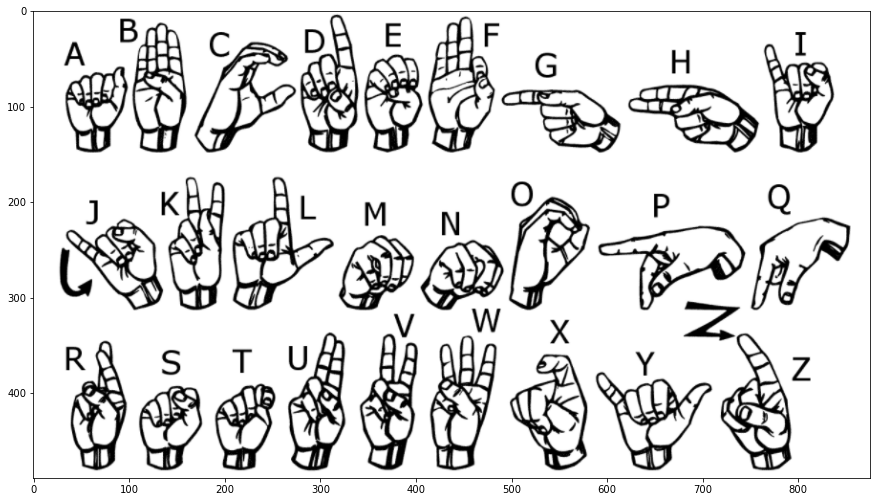

In [4]:
img = mpimg.imread("../Datos/american_sign_language.PNG")
plt.figure(figsize = (15, 12))
plt.imshow(img)

### The labels are the value of the position in which each letter is found in the alphabet (starting from 0). I will relate each letter to its index in order to reference the images.

### Las etiquetas son el valor de la posición en la que se encuentra cada letra en el abecedario (empezando desde 0). Voy a relacionar cada letra con su índice para poder referenciar las imágenes.

In [5]:
sig_labels = {}
letras = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for i in range (26):
    sig_labels[i] = letras[i]

### The platform has separate training and test sets, so I will use that distribution and refrain from evaluating the model on the test set until it is complete.

### La plataforma tiene separados los conjuntos de entrenamiento y prueba, por lo que utilizaré esa distribución, sin evaluar el modelo en el conjunto de prueba hasta que esté completado.

In [6]:
train_val_set = pd.read_csv("../Datos/sign_mnist_train.csv")

train_val_y_df = train_val_set["label"]
train_val_X_df = train_val_set.drop("label", axis = "columns")

train_val_y = train_val_y_df.to_numpy()
train_val_X = train_val_X_df.to_numpy()

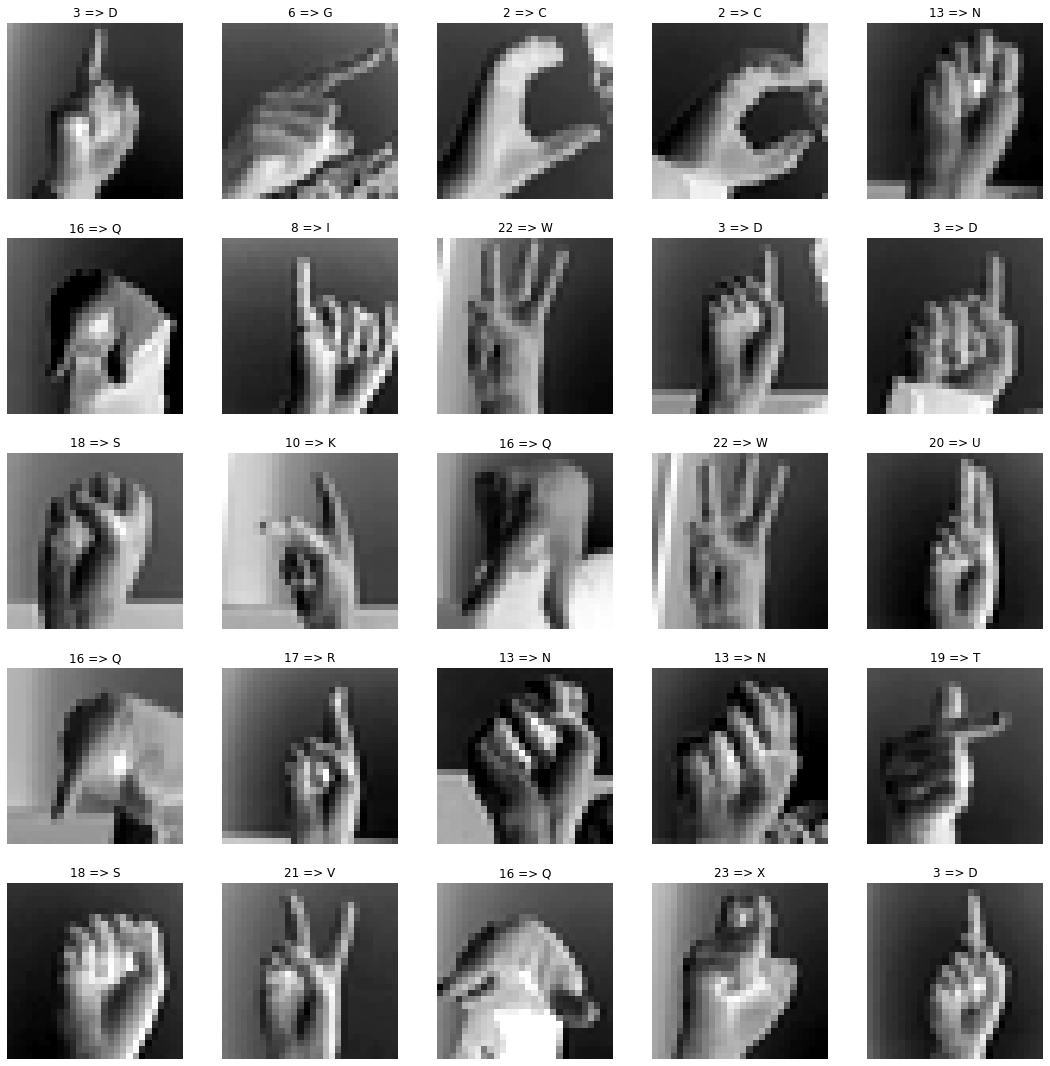

In [7]:
examples25 = train_val_X[0 : 25]

figs, axs = plt.subplots(5, 5, figsize = (15, 15))
contr = 0 # row
contc = 0 # column
figs.tight_layout(pad = 0.5)
for i in range(25):
    axs[contr, contc].imshow(examples25[i].reshape(28, 28), cmap = mpl.cm.binary)
    axs[contr, contc].set_title("%s => %s" %(train_val_y[i], sig_labels[train_val_y[i]]))
    axs[contr, contc].axis("off")
    contc += 1
    if contc == 5:
        contr += 1
        contc = 0

#### It is important for the images to be shuffled (not arranged in alphabetical order, such as all A first, then B, etc.) as some models are sensitive to the order of elements and can produce poor results if they are not properly shuffled. Analyzing the first 25 samples, we can see that they are already shuffled.

#### Es importante que las imagenes esten mezcladas (que no sean primero todas A, luego B, ...) ya que algunos modelos son sensibles al orden de los elementos, y obtienen malos resultados si no estan bien mezclados. Analizando las primeras 25 muestras vemos que ya están mezcladas.

#### I am going to triple the size of the training and validation sets using artificial data extension.

#### Voy a utilizar la extensión artificial para triplicar el tamaño del conjunto de entrenamiento y validación.

In [8]:
train_val_X_for_extension = train_val_X.reshape(27455, 28, 28, 1).copy()

In [9]:
datagen1 = ImageDataGenerator(width_shift_range = 0.15, height_shift_range = 0.1)
X_new_1_raw = datagen1.flow(train_val_X_for_extension, shuffle = False, batch_size = 27455)

datagen2 = ImageDataGenerator(rotation_range = 20)
X_new_2_raw = datagen2.flow(train_val_X_for_extension, shuffle = False, batch_size = 27455)

In [10]:
X_new_1 = X_new_1_raw[0].copy()
X_new_2 = X_new_2_raw[0].copy()

In [11]:
X_train_val_extended = np.concatenate((train_val_X_for_extension, X_new_1, X_new_2), axis = 0)
y_train_val_extended = np.concatenate((train_val_y, train_val_y, train_val_y))

In [12]:
X_train_val_extended.shape, y_train_val_extended.shape

((82365, 28, 28, 1), (82365,))

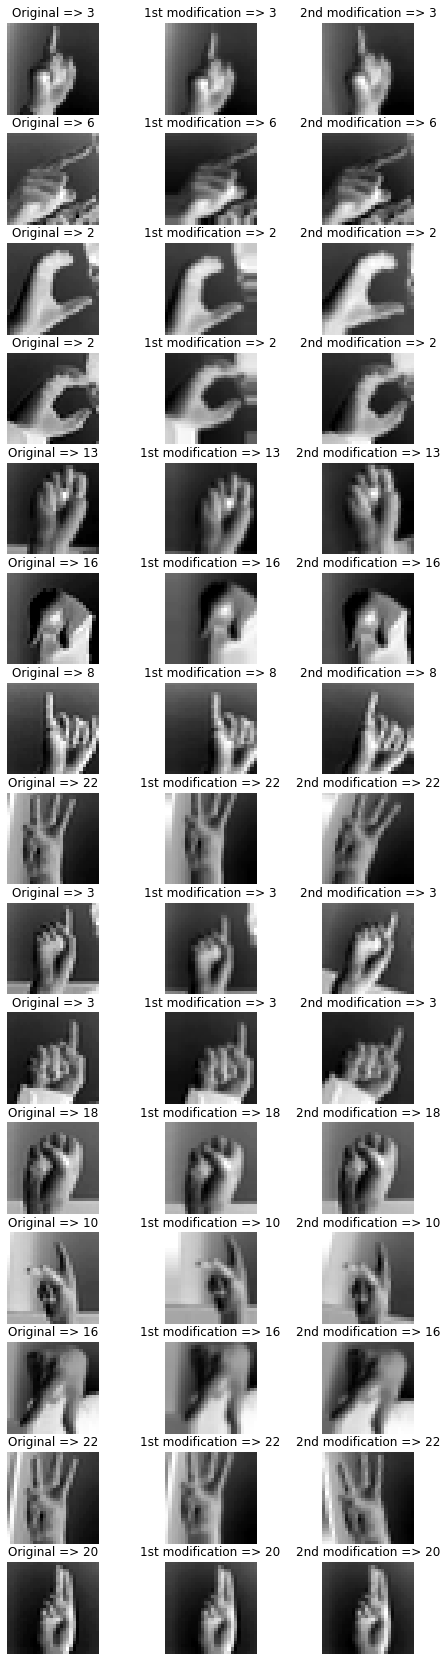

In [13]:
figs, axs = plt.subplots(15, 3, figsize = (8, 30))
contf = 0
contc = 0

for i in range(15):  
    
    axs[i, 0].imshow(X_train_val_extended[i], cmap = mpl.cm.binary)
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(X_train_val_extended[27455 + i], cmap = mpl.cm.binary)
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(X_train_val_extended[27455 * 2 + i], cmap = mpl.cm.binary)
    axs[i, 2].axis("off")
    
    axs[i, 0].set_title("Original => %s" %(y_train_val_extended[i]))
    axs[i, 1].set_title("1st modification => %s" %(y_train_val_extended[27455 + i]))  
    axs[i, 2].set_title("2nd modification => %s" %(y_train_val_extended[27455 * 2 + i])) 
    

##### Now, I will shuffle the complete dataset and divide it into the training set and the validation set. Although the random forest does not use the validation set for training, comparing the accuracies obtained on the test and validation sets will allow me to assess if the model can generalize well to both similar samples used in training and relatively different samples.

##### Ahora voy a mezclar el conjunto completo y dividirlo en el conjunto de entrenamiento y el conjunto de validación. Aunque el bosque aleatorio no utiliza el conjunto de validación para el entrenamiento, al comparar la precisión la precisiones obtenidas en los conjuntos de prueba y validación podré valorar si el modelo es capaz de generalizar correctamente tanto a muestras parecidas a las utilizadas en el entrenamiento como a muestras relativamente diferentes.

In [14]:
X_train_val_sf , y_train_val_sf = shuffle(X_train_val_extended, y_train_val_extended)

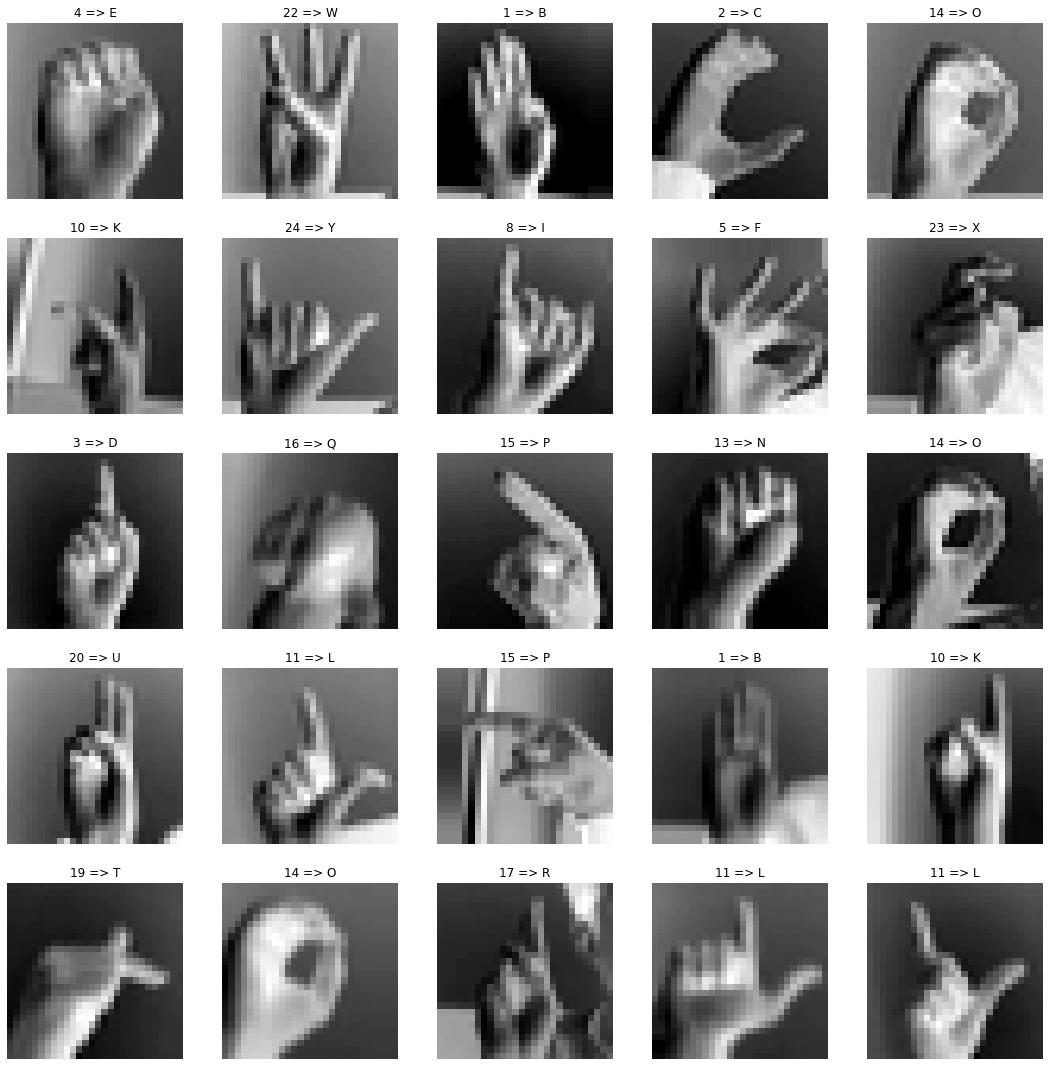

In [15]:
figs, axs = plt.subplots(5, 5, figsize = (15, 15))
contr = 0
contc = 0
figs.tight_layout(pad = 0.5)
for i in range(25):
    axs[contr, contc].imshow(X_train_val_sf[i], cmap = mpl.cm.binary)
    axs[contr, contc].set_title("%s => %s" %(y_train_val_sf[i], sig_labels[y_train_val_sf[i]]))
    axs[contr, contc].axis("off")
    contc += 1
    if contc == 5:
        contr += 1
        contc = 0

##### I will rescale the pixel values from the range [0, 255] to [0, 1].

##### Voy a reducir el rango de los valores de los píxeles desde [0, 255] hasta [0, 1].

In [16]:
X_train = X_train_val_sf[0 : 75000].copy().reshape(75000, 784) / 255.0
y_train = y_train_val_sf[0 : 75000].copy()

X_val = X_train_val_sf[75000 : ].copy().reshape(82365 - 75000, 784) / 255.0
y_val = y_train_val_sf[75000 :].copy()

##### The tests conducted with Grid Search on decision trees have indicated that better results are obtained using entropy as the cost function instead of Gini impurity. Additionally, I performed a Random Search analyzing 30 random forests between the following combinations: maximum tree depth between 10 and 20, and between 400 and 700 trees in each forest. 
##### The forest that achieved the best results consists of 646 trees and has a maximum depth of 19. Therefore, I will create another random forest with these hyperparameters.

##### Las pruebas realizadas con Grid Search en árboles de decisión me han indicado que se obtienen mejores resultados utilizando como función de coste la entropía en lugar de la impureza Gini. Además, he realizado un Random Search analizando 30 bosques aleatorios entre las siguientes combinaciones: profundidad máxima de los árboles entre 10 y 20 y entre 400 y 700 árboles en cada bosque. 
##### El bosque que ha obtenido los mejores resultados esta formado por 646 árboles y tiene una profundidad máxima de 19. Así que voy a crear otro bosque aleatorio con estos hiperparámetros.

In [17]:
forest_clf = RandomForestClassifier(n_estimators = 646, max_depth = 19,
                                    criterion = "entropy", bootstrap = True)

In [18]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=19, n_estimators=646)

### Now I am going to evaluate the random forest using the training and validation sets.

### Ahora voy a evaluar el bosque aleatorio mediante los conjuntos de entrenamiento y validación:

In [19]:
pred_forest_train = forest_clf.predict(X_train)
pred_forest_val = forest_clf.predict(X_val)

In [20]:
def accuracy_calculator(pred1, pred2):
    
    sum = 0
    for i in range(len(pred1)):
        if pred1[i] == pred2[i]:
            sum += 1
    return sum/(len(pred1))  

In [22]:
accuracy_calculator(y_train, pred_forest_train), accuracy_calculator(y_val, pred_forest_val)

(1.0, 0.9549219280380177)

### The results obtained in both sets have been incredibly good, achieving 100% accuracy on the training set and 95.49% accuracy on the validation set. 
### Now I will evaluate the model on the test set:

### Los resultados obtenidos en ambos conjuntos han sido increblemente buenos, obteniendo una precisión del 100% en el conjunto de entrenamiento y una precisión del 95.49% en el conjunto de validación.
### Ahora evaluaré el modelo en el conjunto de prueba:

In [24]:
test_set = pd.read_csv("../Datos/sign_mnist_test.csv")

test_y_df = test_set["label"]
test_X_df = test_set.drop("label", axis = "columns")

test_y = test_y_df.to_numpy()
test_X = test_X_df.to_numpy()

In [25]:
test_X.shape, test_y.shape

((7172, 784), (7172,))

In [26]:
X_test = test_X.copy() / 255.0
y_test = test_y.copy()

In [27]:
pred_forest_test = forest_clf.predict(X_test)

In [28]:
accuracy_calculator(y_test, pred_forest_test)

0.9347462353597323

## The accuracy of the random forest on the test set is 93.47%!!
## The random forest correctly predicted 7118 samples out of the 6704 samples in the test set.

## ¡¡La precisión del bosque aleatorio en el conjunto de prueba es del 93.47%!!
## La red ha predicho correctamente 6704 muestras de las 7172 que contiene el conjunto de prueba.

## I will draw the confusion matrix to analyze the errors made by the random forest.

## Voy a dibujar la matriz de confusión analizando los errores cometidos por el bosque aleatorio.

In [29]:
conf_mx = confusion_matrix(y_test, pred_forest_test)

In [30]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


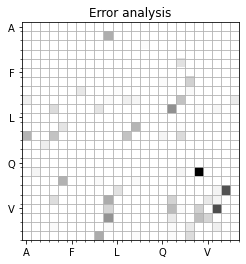

<Figure size 1440x1440 with 0 Axes>

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
minor_tick = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5,
              11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
              20.5, 21.5, 22.5, 23.5, 24.5]
ax.set_xticks(minor_tick, minor=True)
ax.set_yticks(minor_tick, minor=True)
ax.imshow(norm_conf_mx, cmap = plt.cm.gray.reversed())

labels = list("AAFLQV")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.grid(which='minor', alpha=1)

plt.title("Error analysis")
plt.figure(figsize = (20, 20))
plt.show()

## Conclusión:

### El bosque aleatorio obtenido ha obtenido unas precisiones del 100% y 95.49% en los conjuntos de entrenamiento y validación, respectivamente. Aunque se ha definido un conjunto de validación, este no se ha utilizado en ningún momento para la puesta a punto del modelo, por lo que puede considerarse un conjunto de prueba extra. Por otro lado, la precisión obtenida en el conjunto de prueba ha sido del 93.47%.

### Los resultados obtenidos indican que existe cierto sobreajuste, pero no es muy acentuado debido a que los resultados obtenidos en los conjuntos de validación y prueba son muy bueno. De esta forma, el bosque aleatorio obtenido puede considerarse un modelo eficaz para afrontar la tarea abordada.

## Conclusion:

### The obtained random forest has achieved accuracies of 100% and 95.49% on the training and validation sets, respectively. Although a validation set was defined, it was not used at any point for model fine-tuning, making it an additional test set. Furthermore, the accuracy obtained on the test set was 93.47%.

### The results indicate some degree of overfitting, although it is not very pronounced since the accuracies obtained on the validation and test sets are still quite good. Therefore, the obtained random forest can be considered an effective model for addressing the task at hand.